In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.spatial import ConvexHull
import cv2
from scipy.spatial.distance import cdist

## Utility Functions

In [2]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
            path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def plot_shape(csv_path):
    csv_curve = read_csv(csv_path)
    plot(csv_curve)
    print("Number of curves:", len(csv_curve))

In [74]:
def get_corners(points, epsilon_factor=0.02):
    # Convert points to a format suitable for OpenCV
    points = np.array(points, dtype=np.float32).reshape((-1, 1, 2))
    
    # Calculate the perimeter of the shape
    perimeter = cv2.arcLength(points, True)
    
    # Approximate the contour with a polygon
    epsilon = epsilon_factor * perimeter
    approx = cv2.approxPolyDP(points, epsilon, True)
    
    # Extract corners from the approximation
    corners = [tuple(pt[0]) for pt in approx]
    
    return corners

def plot_shape_and_corners(points, corners):
    points = np.array(points)
    
    plt.figure(figsize=(8, 6))
    plt.plot(points[:, 0], points[:, 1], 'o-', label='Original Shape')
    
    corners = np.array(corners)
    plt.plot(corners[:, 0], corners[:, 1], 'ro', label='Corners')
    
    # for corner in corners:
    #     plt.text(corner[0], corner[1], f'({corner[0]}, {corner[1]})', fontsize=12, color='red')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Shape and Corners')
    plt.show()

def plot_convex_hull(points):
    # Convert points to a numpy array
    points = np.array(points)
    
    # Compute the convex hull
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    
    # Plot the original points
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], color='red', s=10, label='Original Points')
    
    # Plot the convex hull
    plt.plot(np.append(hull_points[:, 0], hull_points[0, 0]), np.append(hull_points[:, 1], hull_points[0, 1]), color='blue', linestyle='-', label='Convex Hull')
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.title('Original Points and Convex Hull')
    plt.show()

## Curve Identification

In [48]:
class CurveIdentification:
    def __init__(self, curve):
        self.curve = curve
    
    def is_straight_line(self, threshold=0.99):
        x = np.array([p[0] for p in self.curve]).reshape(-1, 1)
        y = np.array([p[1] for p in self.curve])
        
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        
        r2 = r2_score(y, y_pred)
        return r2 >= threshold
    
    def is_convex_shape(self, threshold=100):
        self.curve = np.array(self.curve)
        
        # Compute the convex hull
        hull = ConvexHull(self.curve)
        
        # Compute the area of the original shape
        original_area = 0.5 * np.abs(np.dot(self.curve[:, 0], np.roll(self.curve[:, 1], 1)) - np.dot(self.curve[:, 1], np.roll(self.curve[:, 0], 1)))
        
        # Compute the area of the convex hull
        hull_points = self.curve[hull.vertices]
        hull_area = 0.5 * np.abs(np.dot(hull_points[:, 0], np.roll(hull_points[:, 1], 1)) - np.dot(hull_points[:, 1], np.roll(hull_points[:, 0], 1)))
        
        # Difference in area
        area_difference = hull_area - original_area
        
        return area_difference <= threshold
    
    def is_ellipse_or_circle(self, threshold=0.95):
        self.curve = np.array(self.curve)
    
        # Compute area using the Shoelace formula
        def polygon_area(pts):
            return 0.5 * np.abs(np.dot(pts[:, 0], np.roll(pts[:, 1], 1)) - np.dot(pts[:, 1], np.roll(pts[:, 0], 1)))
        
        # Compute perimeter
        def polygon_perimeter(pts):
            return np.sum(np.sqrt(np.sum(np.diff(np.vstack([pts, pts[0]]), axis=0)**2, axis=1)))
        
        area = polygon_area(self.curve)
        perimeter = polygon_perimeter(self.curve)
        
        # Compute circularity
        circularity = 4 * np.pi * area / (perimeter ** 2)
        
        return circularity >= threshold
    
    def is_circle(self, threshold=0.8):
        # get bounding box around shape
        self.curve = np.array(self.curve)
        min_x = np.min(self.curve[:, 0])
        max_x = np.max(self.curve[:, 0])
        min_y = np.min(self.curve[:, 1])
        max_y = np.max(self.curve[:, 1])

        # find aspect ratio of bounding box
        width = max_x - min_x
        height = max_y - min_y
        if height < width :
            width, height = height, width
        aspect_ratio = width / height

        return aspect_ratio >= threshold
    
    def identify(self):
        if self.is_straight_line() :
            return "Line"
        else:
            if self.is_convex_shape() :
                if self.is_ellipse_or_circle() :
                    if self.is_circle() :
                        return "Circle"
                    else :
                        return "Ellipse"
                else :
                    return "Regular Polygon"
            else :
                return "Non-convex Star"

In [27]:
polylines = read_csv(r"C:\Users\suyash\OneDrive - iiit-b\Projects\Adobe_GenSolve\problems\problems\isolated.csv")

In [49]:
iden1 = CurveIdentification(polylines[0][0])
iden1.identify()

'Circle'

In [50]:
iden2 = CurveIdentification(polylines[1][0])
iden2.identify()

'Non-convex Star'

In [51]:
iden3 = CurveIdentification(polylines[2][0])
iden3.identify()

'Regular Polygon'

## Curve Fitting

In [118]:
class CurveFitting :
    def __init__ (self, curve):
        self.curve = curve

    def fit_line(self):
        return
    
    def fit_circle(self):
        def get_circle(circle_list):
            # calculate circle center using mean
            x, y = zip(*circle_list)
            x_center = np.mean(x)
            y_center = np.mean(y)

            # rearrange points such that origin becomes center
            u = x - x_center
            v = y - y_center

            # get radius by solving least mean squared error 
            distances = np.sqrt(u**2 + v**2)
            radius = np.mean(distances)

            # print(x_center, y_center, radius)
            return x_center, y_center, radius
    
        # plot original curve
        fig, ax = plt.subplots(tight_layout=True, figsize=(6, 6))
        colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
        c = colours[0]
        
        ax.plot(self.curve[:, 0], self.curve[:, 1], c=c, linewidth=2)

        # plot regularized curve
        x_center, y_center, radius = get_circle(self.curve)
        
        # Create an array of angles for the circle
        theta = np.linspace(0, 2 * np.pi, 100)
        
        # Parametric equations for a circle
        x_circle = x_center + radius * np.cos(theta)
        y_circle = y_center + radius * np.sin(theta)
        
        # Plot the circle and center of circle
        ax.plot(x_circle, y_circle, 'k-', linewidth=4)
        ax.plot(x_center, y_center, 'ro')  # 'ro' for red dot

        # Set equal scaling and labels
        ax.set_aspect('equal')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('original_and_regularized_circle')
        ax.legend()
        
        # Show plot
        # plt.grid(True)
        plt.show()
    
    def fit_ellipse(self):
        # Convert the list of points to a numpy array
        self.curve = np.array(self.curve, dtype=np.float32)
        
        # Fit an ellipse to the points
        ellipse = cv2.fitEllipse(self.curve)
        
        # Extract ellipse parameters
        center, axes, angle = ellipse
        major_axis, minor_axis = axes
        
        # Create points along the ellipse
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_points = np.array([
            center[0] + major_axis / 2 * np.cos(theta) * np.cos(np.radians(angle)) - minor_axis / 2 * np.sin(theta) * np.sin(np.radians(angle)),
            center[1] + major_axis / 2 * np.cos(theta) * np.sin(np.radians(angle)) + minor_axis / 2 * np.sin(theta) * np.cos(np.radians(angle))
        ]).T

        # Plot the original points
        plt.scatter(self.curve[:, 0], self.curve[:, 1], color='red', label='Original Points')
        
        # Plot the fitted ellipse
        plt.plot(ellipse_points[:, 0], ellipse_points[:, 1], 'k-', linewidth=4, label='Fitted Ellipse')
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.title('Original Points and Fitted Ellipse')
        plt.show() 
    
    def fit_rectangle(self):
        # Convert the list of points to a numpy array
        self.curve = np.array(self.curve, dtype=np.float32)
        
        # Fit a rotated rectangle to the points
        rect = cv2.minAreaRect(self.curve)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        # Create a plot
        plt.figure(figsize=(8, 8))
        
        # Plot the original points
        plt.scatter(self.curve[:, 0], self.curve[:, 1], color='red', label='Original Points')
        
        # Plot the fitted rectangle
        plt.plot(np.append(box[:, 0], box[0, 0]), np.append(box[:, 1], box[0, 1]), 'k-', linewidth=4, label='Fitted Rectangle')
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.title('Original Points and Fitted Rectangle')
        plt.show() 
    
    def fit_polygon(self):
        # Get corners of the approximated polygon
        corners = get_corners(self.curve)
        points = np.array(self.curve)
        corners = np.array(corners)

        # Calculate centroid of corners
        centroid = np.mean(corners, axis=0)

        # Find the point with the highest y-value to fix its position
        fixed_point = corners[np.argmax(corners[:, 1])]
        
        # Calculate radius from centroid to the fixed point
        radius = np.linalg.norm(fixed_point - centroid)
        
        # Calculate initial angle of the fixed point from the centroid
        initial_angle = np.arctan2(fixed_point[1] - centroid[1], fixed_point[0] - centroid[0])
        
        # Number of vertices
        num_vertices = len(corners)
        
        # Generate the regular polygon
        regular_polygon = []
        for i in range(num_vertices):
            angle = initial_angle + 2 * np.pi * i / num_vertices
            x = centroid[0] + radius * np.cos(angle)
            y = centroid[1] + radius * np.sin(angle)
            regular_polygon.append((x, y))
        
        regular_polygon = np.array(regular_polygon)
        
        # Plot original shape and fitted polygon
        plt.figure(figsize=(8, 6))
        plt.plot(points[:, 0], points[:, 1], 'o-', label='Original Shape')
        # plt.plot(corners[:, 0], corners[:, 1], 'ro-', label='Fitted Polygon')
        # plt.plot(regular_polygon[:, 0], regular_polygon[:, 1], 'g--', label='Regular Polygon')

        # Draw lines between consecutive points of the regular polygon
        for i in range(num_vertices):
            start_point = regular_polygon[i]
            end_point = regular_polygon[(i + 1) % num_vertices]
            plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k-', linewidth=4)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title('Original Shape and Fitted Polygon')
        plt.show()
    
    def fit_star(self):
        # Get corners of the approximated polygon
        corners = get_corners(self.curve)
        points = np.array(self.curve)
        corners = np.array(corners)

        # Calculate centroid of corners
        centroid = np.mean(corners, axis=0)

        # Calculate distances from the centroid
        distances = np.linalg.norm(corners - centroid, axis=1)

        # Separate outer and inner points based on distances
        sorted_indices = np.argsort(distances)
        half = len(corners) // 2

        outer_points = corners[sorted_indices[half:]]
        inner_points = corners[sorted_indices[:half]]

        # Find the fixed outer point with the highest y-value
        fixed_outer_point = outer_points[np.argmax(outer_points[:, 1])]
        
        # Calculate radius for outer and inner points
        outer_radius = np.linalg.norm(fixed_outer_point - centroid)
        inner_radius = np.mean([np.linalg.norm(pt - centroid) for pt in inner_points])

        # Calculate initial angle of the fixed outer point from the centroid
        initial_angle = np.arctan2(fixed_outer_point[1] - centroid[1], fixed_outer_point[0] - centroid[0])

        # Number of vertices
        num_vertices = len(corners) // 2

        # Generate the star points
        star_points = []
        for i in range(num_vertices):
            # Calculate the angle for the outer point
            angle_outer = initial_angle + 2 * np.pi * i / num_vertices
            x_outer = centroid[0] + outer_radius * np.cos(angle_outer)
            y_outer = centroid[1] + outer_radius * np.sin(angle_outer)
            star_points.append((x_outer, y_outer))

            # Calculate the angle for the inner point (between two outer points)
            angle_inner = initial_angle + 2 * np.pi * (i + 0.5) / num_vertices
            x_inner = centroid[0] + inner_radius * np.cos(angle_inner)
            y_inner = centroid[1] + inner_radius * np.sin(angle_inner)
            star_points.append((x_inner, y_inner))

        star_points = np.array(star_points)

        # Plot original shape and fitted star
        plt.figure(figsize=(8, 6))
        plt.plot(points[:, 0], points[:, 1], 'o-', label='Original Shape')
        # plt.plot(corners[:, 0], corners[:, 1], 'ro-', label='Fitted Polygon')
        # plt.plot(star_points[:, 0], star_points[:, 1], 'k-', linewidth=2, label='Fitted Star')

        # Draw lines between consecutive points of the star
        for i in range(len(star_points)):
            start_point = star_points[i]
            end_point = star_points[(i + 1) % len(star_points)]
            plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k-', linewidth=4)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title('Original Shape and Fitted Star')
        plt.show()
    
    def fit_convex_hull(self):
        # Convert points to a numpy array
        self.curve = np.array(self.curve)
        
        # Compute the convex hull
        hull = ConvexHull(self.curve)
        hull_points = self.curve[hull.vertices]
        
        # Plot the original points
        plt.figure(figsize=(8, 8))
        plt.scatter(self.curve[:, 0], self.curve[:, 1], color='red', s=10, label='Original Points')
        
        # Plot the convex hull
        plt.plot(np.append(hull_points[:, 0], hull_points[0, 0]), np.append(hull_points[:, 1], hull_points[0, 1]), color='blue', linestyle='-', label='Convex Hull')
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.title('Original Points and Convex Hull')
        plt.show()

    def fit_curve(self, curve_type):
        if curve_type == "Circle":
            self.fit_circle()
        elif curve_type == "Ellipse":
            self.fit_ellipse()
        elif curve_type == "Line":
            self.fit_line()
        elif curve_type == "Rectangle":
            # self.fit_rectangle()
            self.fit_polygon()
        elif curve_type == "Star":
            self.fit_star()
        elif curve_type == "Regular Polygon":
            self.fit_polygon()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


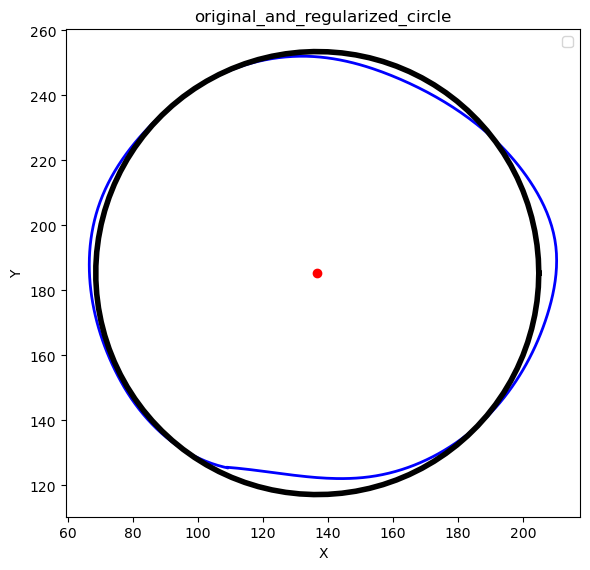

In [119]:
fitting1 = CurveFitting(polylines[0][0])
fitting1.fit_circle()

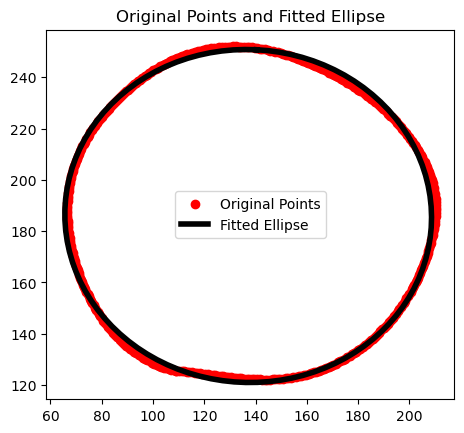

In [112]:
fitting1.fit_ellipse()

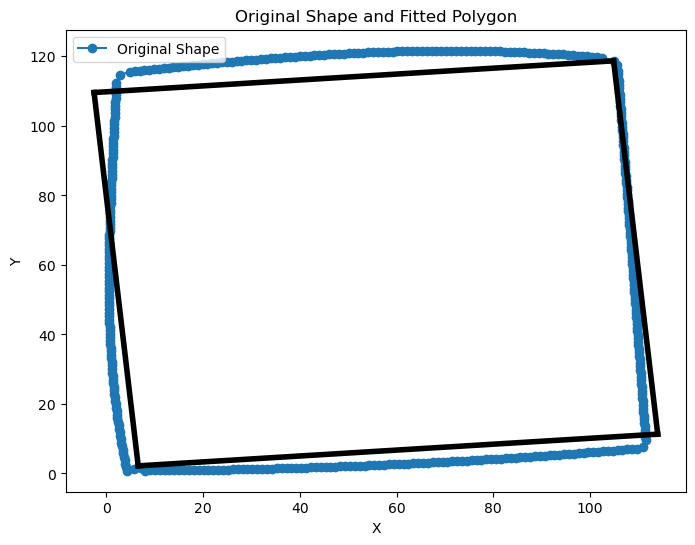

In [113]:
fitting2 = CurveFitting(polylines[2][0])
fitting2.fit_polygon()

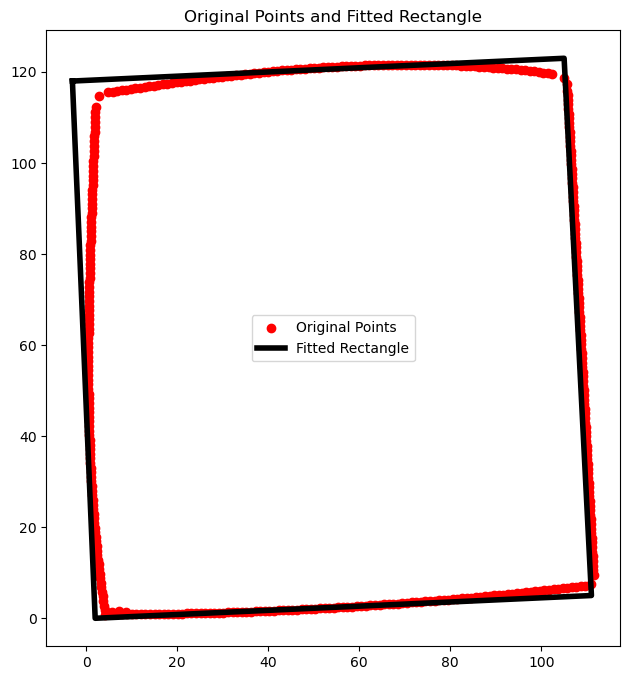

In [114]:
fitting4 = CurveFitting(polylines[2][0])
fitting4.fit_rectangle()

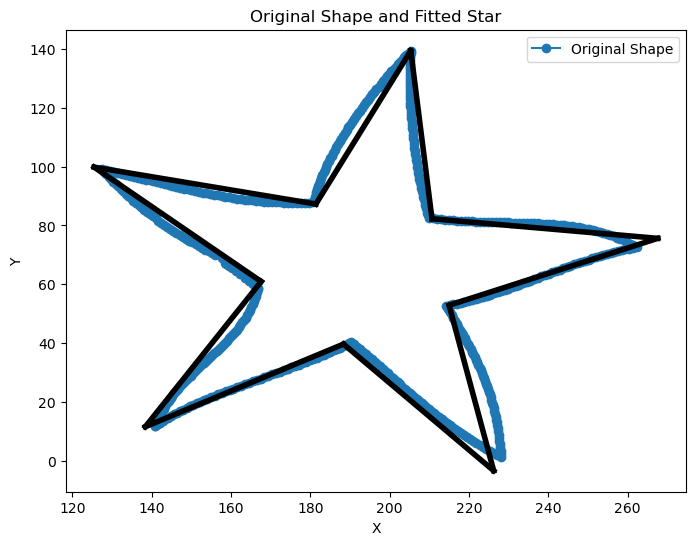

In [115]:
fitting3 = CurveFitting(polylines[1][0])
fitting3.fit_star()

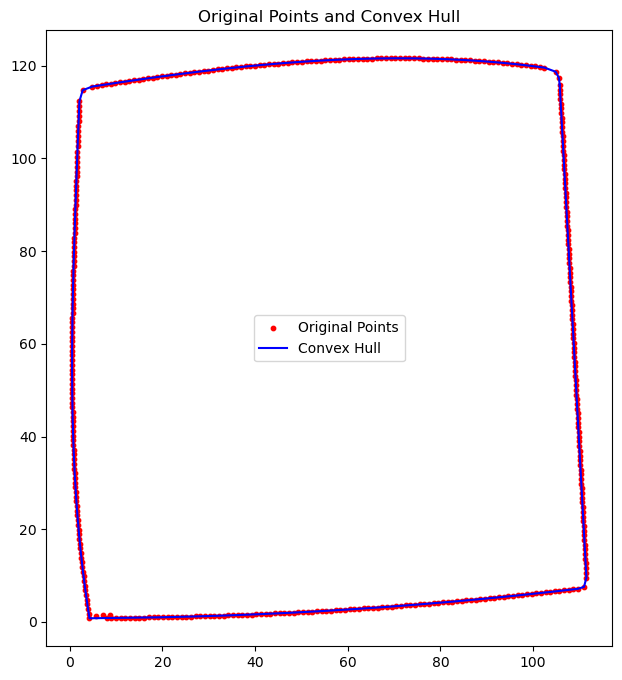

In [63]:
fitting2.fit_convex_hull()

## Regularization

In [83]:
class Regularize:
    def __init__(self, curve):
        self.curve = curve

    def regularize(self):
        curve_identification = CurveIdentification(self.curve)
        curve_type = curve_identification.identify()

        curve_fitting = CurveFitting(self.curve)
        curve_fitting.fit_curve(curve_type)    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


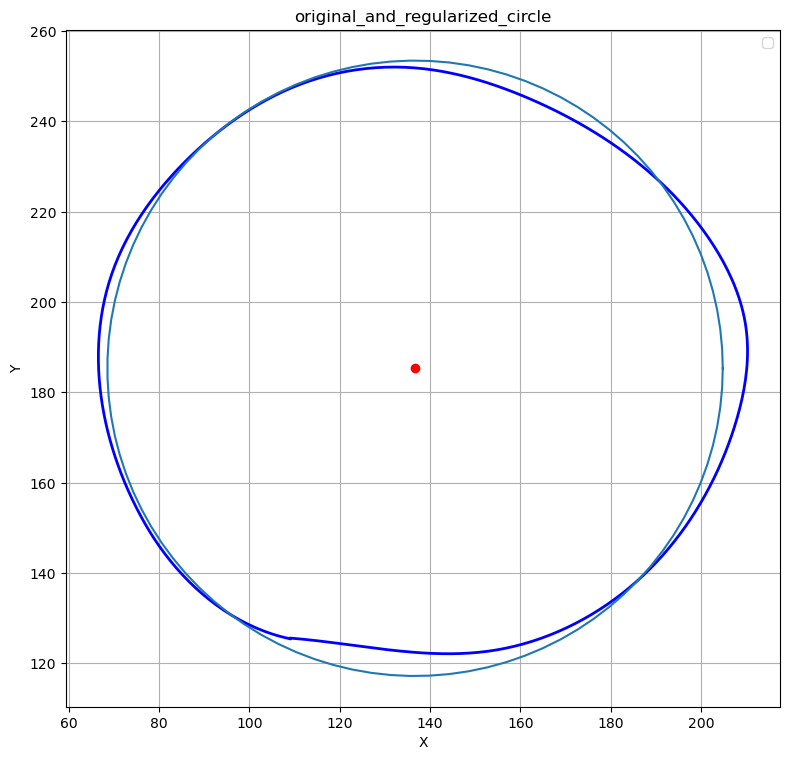

In [67]:
regular = Regularize(polylines[0][0])
regular.regularize()

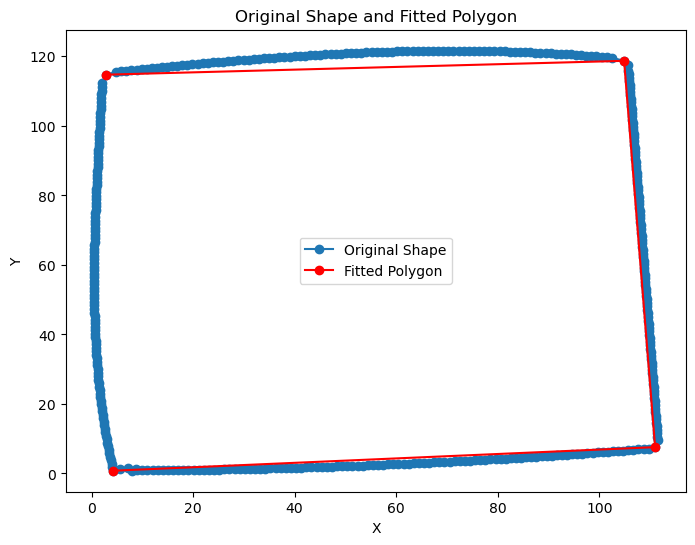

In [84]:
regular2 = Regularize(polylines[2][0])
regular2.regularize()

## Symmetry

In [75]:
class Symmetry:
    def __init__(self, curve):
        self.curve = curve
    
    def line_symmetry(self, curve_type):
        return
    
    def radial_symmetry(self, curve_type):
        if curve_type == "Circle" :
            x, y = zip(*self.curve)
            x_center = np.mean(x)
            y_center = np.mean(y)
            return x_center, y_center
        
        elif curve_type == "Regular Polygon" :
            get_corners()
    
    def get_symmetry(self, curve_type):
        self.line_symmetry(curve_type)
        self.radial_symmetry(curve_type)
        

Corners: [(140.844, 11.847), (190.326, 40.5), (228.09, 1.226), (214.2, 52.654), (262.277, 72.643), (209.859, 82.605), (205.319, 139.337), (180.777, 87.813), (127.422, 99.151), (166.888, 58.292)]


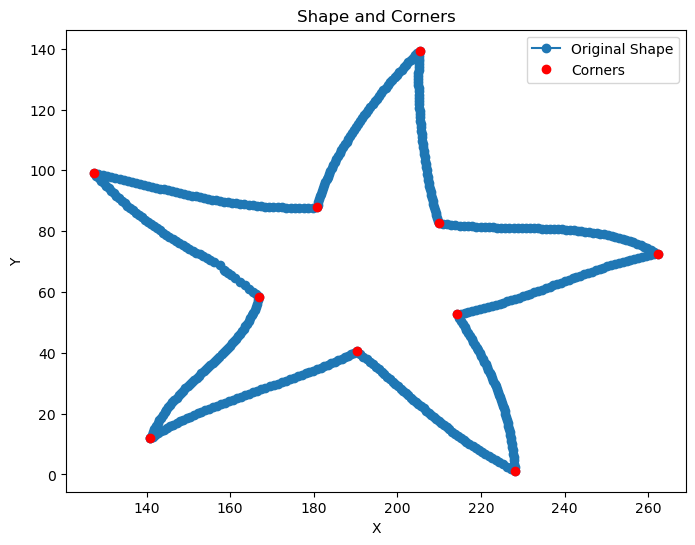

In [76]:
corners = get_corners(polylines[1][0])
print("Corners:", corners)
plot_shape_and_corners(polylines[1][0], corners)

Corners: [(4.26, 0.779), (110.979, 7.56), (104.871, 118.715), (2.792, 114.73)]


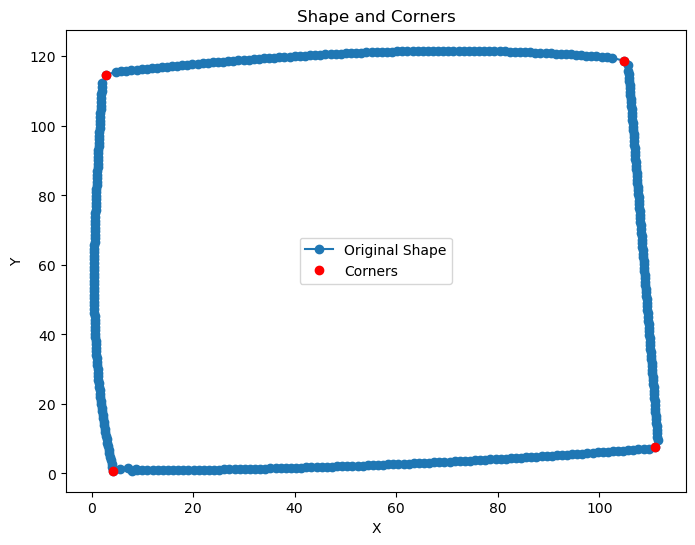

In [72]:
corners2 = get_corners(polylines[2][0])
print("Corners:", corners2)
plot_shape_and_corners(polylines[2][0], corners2)